In [2]:
import os
import glob
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

/opt/conda/shared/envs/ni38/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
%matplotlib inline

# VBM

## Template

In [3]:
from nilearn.image import concat_imgs, mean_img

In [4]:
data_dir = '../../data_VBM/selec/sub-031624_sub-031673/derivatives_mni/smriprep'

In [5]:
GM_probmap_files = glob.glob(os.path.join(data_dir, "sub-*", "anat", "*MNI*GM_probseg.nii.gz"))

In [6]:
GM_probmaps_4D_img = concat_imgs(GM_probmap_files)

In [7]:
GM_probmap_mean_img = mean_img(GM_probmaps_4D_img)

In [8]:
GM_probmap_mean_data = GM_probmap_mean_img.get_fdata()

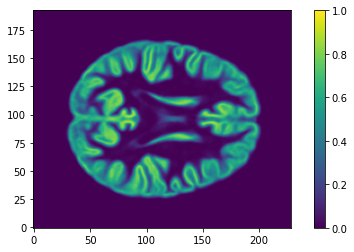

In [9]:
plt.figure(figsize=(8, 4))
plt.imshow(GM_probmap_mean_data[:, :, 100], origin="lower", vmin=0, vmax=1)
plt.colorbar();

Resample to 2-mm template

In [12]:
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img

In [13]:
template = load_mni152_template()
GM_probmap_mean_img_2mm = resample_to_img(GM_probmap_mean_img, template)

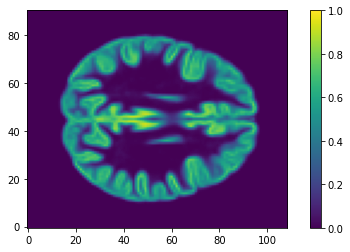

In [16]:
plt.figure(figsize=(8, 4))
plt.imshow(GM_probmap_mean_img_2mm.get_fdata()[:, :, 50], origin="lower", vmin=0, vmax=1)
plt.colorbar();

Save image

In [17]:
GM_probmap_mean_img.to_filename(os.path.join(data_dir, "GM_template.nii.gz"))
GM_probmap_mean_img_2mm.to_filename(os.path.join(data_dir, "GM_template_2mm.nii.gz"))

### Compute deformations (do not run in this notebook)

In [ ]:
%%bash
NATIVE_GM_MAPS=(data/derivatives_mni/smriprep/sub-*/anat/sub-[0-9][0-9][0-9][0-9][0-9][0-9]_label-GM_probseg.nii.gz)
for GM_MAP in ${NATIVE_GM_MAPS[@]}; do 
    SUBJ_NAME=${GM_MAP%%_label*}
    fsl_reg ${GM_MAP} GM_template_2mm.nii.gz ${SUBJ_NAME}_space-MNIGMTemplate_label-GM_probseg \
            -fnirt "--config=GM_2_MNI152GM_2mm.cnf --jout=${SUBJ_NAME}_JAC_nl"
done

In [6]:
a = np.array([[1, 2, 3], [4, 5, 6]])
a

array([[1, 2, 3],
       [4, 5, 6]])

In [7]:
b = np.array([[2, 2, 2], [3, 3, 3]])
b

array([[2, 2, 2],
       [3, 3, 3]])

In [8]:
a * b

array([[ 2,  4,  6],
       [12, 15, 18]])

### Estimate GM modulated maps

In [10]:
!ls ../../data

 atlases			      oasis_cross-sectional_disc2
 dataset_description.json	      oasis_cross-sectional_disc2.tar.gz
 ds000105			      oasis_cross-sectional_disc5.tar.gz
 guest-20210420_104434.zip	      oasis_cross-sectional_disc5.tar.gz.part
 guest-20210420_110356.xml	      oasis_cs_freesurfer_disc2
 MS_Patient15			      oasis_cs_freesurfer_disc2.tar.gz
 oasis_cross-sectional.csv	     'Unconfirmed 894241.crdownload'
 oasis_cross-sectional_disc1	      XNAT-Desktop-Client-2.0.4.AppImage
 oasis_cross-sectional_disc1.tar.gz


In [11]:
data_dir = '../../data_VBM/selec/sub-031624_sub-031673/derivatives_mni/smriprep'

In [ ]:
GM_xformed_probmap_files = glob.glob(os.path.join(data_dir, "sub-*", "anat", "*template*GM_probseg.nii.gz"))
# Calculating 
for i_probmap in range(len(GM_probmap_files)):
    
    # Get transformed map
    xform_map_file = GM_xformed_probmap_files[i_probmap]
    xform_map = nib.load(xform_map_file)
    # Get scaling factors (trace of Jacobian)
    scaling_factors_map_file = xform_map_file.replace(".nii.gz", "_JAC.nii.gz")
    scaling_factors_map = nib.load(scaling_factors_map_file)
    # Compute modulated map
    modulated_map_data = math_img("img1 + img2",
...                       img1=anatomical_image, img2=log_img)
    
    modulated_map_data = xform_map.get_fdata() * scaling_factors_map.get_fdata()
    
    print(f"Probmap {i_probmap} (0-indexed)")
    tmp_GM_probmap_file = GM_probmap_files[i_probmap]
    tmp_GM_probmap = nib.load(tmp_GM_probmap_file)
    if not np.array_equal(tmp_GM_probmap.affine, GM_probmap_affine):
        print("Warning, different affines")
    GM_probmap_data += tmp_GM_probmap.get_fdata()
GM_probmap_mean = GM_probmap_data / len(GM_probmap_files)

In [18]:
!ls ../../data_VBM/selec/sub-031624_sub-031673/derivatives_mni/smriprep/sub-031626/anat/sub-031626_space-MNIGMtemplate_label-GM_probseg.nii.gz

test_sub


In [ ]:
for g in `$FSLDIR/bin/imglob *_struc.*` ; do
  echo $g
  echo "${FSLDIR}/bin/fsl_reg ${g}_GM template_GM ${g}_GM_to_template_GM -fnirt \"--config=GM_2_MNI152GM_2mm.cnf --jout=${g}_JAC_nl\"; \
        $FSLDIR/bin/fslmaths ${g}_GM_to_template_GM -mul ${g}_JAC_nl ${g}_GM_to_template_GM_mod -odt float" >> fslvbm3a
done

\$FSLDIR/bin/fslmerge -t GM_merg     \`\${FSLDIR}/bin/imglob ../struc/*_GM_to_template_GM.*\`
\$FSLDIR/bin/fslmerge -t GM_mod_merg \`\${FSLDIR}/bin/imglob ../struc/*_GM_to_template_GM_mod.*\`

\$FSLDIR/bin/fslmaths GM_merg -Tmean -thr 0.01 -bin GM_mask -odt char

/bin/cp ../design.* .

for i in GM_mod_merg ; do
  for j in 2 3 4 ; do
    \$FSLDIR/bin/fslmaths \$i -s \$j \${i}_s\${j} 
    \$FSLDIR/bin/randomise -i \${i}_s\${j} -o \${i}_s\${j} -m GM_mask -d design.mat -t design.con -V
  done
done

echo "Once this has finished, run randomise with 5000 permutations on the 'best' smoothed 4D GM_mod_merg. We recommend using the -T (TFCE) option. For example:"
echo "randomise -i GM_mod_merg_s3 -o GM_mod_merg_s3 -m GM_mask -d design.mat -t design.con -n 5000 -T -V"

In [10]:
!ls

1_sMRI_modalities.ipynb			  6_sMRI_StatisticalAnalysis.ipynb
2_sMRI_image_cleanup.ipynb		  7_sMRI_reproducibility.ipynb
3_sMRI_spatial_norm.ipynb		  Stats.ipynb
4_sMRI_segmentation_quantification.ipynb


#### More memory efficient ?

In [36]:
# Get first GM probability map
i_probmap = 0
GM_probmap_file = GM_probmap_files[0]
GM_probmap = nib.load(GM_probmap_file)
GM_probmap_data = GM_probmap.get_fdata()
GM_probmap_affine = GM_probmap.affine

In [41]:
# Create mean image by summing each image and dividing by total number of images
for i_probmap in range(1, len(GM_probmap_files)):
    print(f"Probmap {i_probmap} (0-indexed)")
    tmp_GM_probmap_file = GM_probmap_files[i_probmap]
    tmp_GM_probmap = nib.load(tmp_GM_probmap_file)
    if not np.array_equal(tmp_GM_probmap.affine, GM_probmap_affine):
        print("Warning, different affines")
    GM_probmap_data += tmp_GM_probmap.get_fdata()
GM_probmap_mean = GM_probmap_data / len(GM_probmap_files)

Probmap 1 (0-indexed)
Probmap 2 (0-indexed)
Probmap 3 (0-indexed)
Probmap 4 (0-indexed)
Probmap 5 (0-indexed)
Probmap 6 (0-indexed)
Probmap 7 (0-indexed)
Probmap 8 (0-indexed)
Probmap 9 (0-indexed)
Probmap 10 (0-indexed)
Probmap 11 (0-indexed)


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8, 4))
plt.imshow(GM_probmap_mean[:, :, 100], origin="lower", vmin=0, vmax=1)
plt.colorbar();

In [ ]:
np.array_equal(GM_probmap_mean, GM_probmap_mean_img)